In [9]:
import random
import sklearn.tree
import pandas as pd
from tree_diff import tree, keep_regrow_alg
from sklearn.metrics import *
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import itertools
from river import evaluate
from river import metrics
from river import tree
from river import stream
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

from tree_diff.tree_ruleset_conversion import *
from tree_diff.similar_tree import *

In [7]:
# Data Engineering for the Datasets

def data_engineering(df, dataset):

    labelencoder = LabelEncoder()
    # The reason for not using the label encoder was to make aware that some jobs or education sector can be
    # pivotal in forming  the decision of the Income. As label encoder tries to fill the values randomly for
    # each category.
    if "adult" in dataset:
        df["class"] = df["class"].map({"<=50K": 0, ">50K": 1})
        df["workclass"] = df["workclass"].map(
            {
                "State-gov": 6,
                "Self-emp-not-inc": 5,
                "Private": 4,
                "Federal-gov": 7,
                "Local-gov": 3,
                np.nan: -1,
                "Self-emp-inc": 2,
                "Without-pay": 1,
                "Never-worked": 0,
            }
        )

        df["education"] = df["education"].map(
            {
                "Bachelors": 10,
                "HS-grad": 9,
                "11th": 6,
                "Masters": 11,
                "9th": 4,
                "Some-college": 8,
                "Assoc-acdm": 13,
                "Assoc-voc": 14,
                "7th-8th": 3,
                "Doctorate": 15,
                "Prof-school": 12,
                "5th-6th": 2,
                "10th": 5,
                "1st-4th": 1,
                "Preschool": 0,
                "12th": 7,
            }
        )

        df["marital-status"] = df["marital-status"].map(
            {
                "Never-married": 6,
                "Married-civ-spouse": 5,
                "Divorced": 0,
                "Married-spouse-absent": 4,
                "Separated": 3,
                "Married-AF-spouse": 2,
                "Widowed": 1,
            }
        )

        df["occupation"] = df["occupation"].map(
            {
                "Adm-clerical": 1,
                "Exec-managerial": 2,
                "Handlers-cleaners": 3,
                "Prof-specialty": 4,
                "Other-service": 5,
                "Sales": 6,
                "Craft-repair": 7,
                "Transport-moving": 8,
                "Farming-fishing": 9,
                "Machine-op-inspct": 10,
                "Tech-support": 11,
                np.nan: 0,
                "Protective-serv": 12,
                "Armed-Forces": 13,
                "Priv-house-serv": 14,
            }
        )

        df["relationship"] = df["relationship"].map(
            {
                "Not-in-family": 1,
                "Husband": 2,
                "Wife": 3,
                "Own-child": 4,
                "Unmarried": 5,
                "Other-relative": 6,
            }
        )

        df["race"] = df["race"].map(
            {
                "White": 1,
                "Black": 2,
                "Asian-Pac-Islander": 3,
                "Amer-Indian-Eskimo": 4,
                "Other": 0,
            }
        )

        df["native-country"] = df["native-country"].map(
            {
                "United-States": 1,
                "Cuba": 2,
                "Jamaica": 3,
                "India": 4,
                np.nan: 0,
                "Mexico": 5,
                "South": 6,
                "Puerto-Rico": 7,
                "Honduras": 8,
                "England": 9,
                "Canada": 10,
                "Germany": 11,
                "Iran": 12,
                "Philippines": 13,
                "Italy": 14,
                "Poland": 15,
                "Columbia": 16,
                "Cambodia": 17,
                "Thailand": 18,
                "Ecuador": 19,
                "Laos": 20,
                "Taiwan": 21,
                "Haiti": 22,
                "Portugal": 23,
                "Dominican-Republic": 24,
                "El-Salvador": 25,
                "France": 26,
                "Guatemala": 27,
                "China": 28,
                "Japan": 29,
                "Yugoslavia": 30,
                "Peru": 31,
                "Outlying-US(Guam-USVI-etc)": 32,
                "Scotland": 33,
                "Trinadad&Tobago": 34,
                "Greece": 35,
                "Nicaragua": 36,
                "Vietnam": 37,
                "Hong": 38,
                "Ireland": 39,
                "Hungary": 40,
                "Holand-Netherlands": 41,
            }
        )

        df["sex"] = df["sex"].map({"Male": 0, "Female": 1})

        return df

    elif "mushroom" in dataset:

        for column in df.columns:
            df[column] = labelencoder.fit_transform(df[column])

        return df

    elif "HIGGS" in dataset:
        df = df.sample(frac=0.001)  # 11000 rows out of 11 million
        df.columns = [
            "prediction",
            "lepton_pT",
            "lepton_eta",
            "lepton_phi",
            "missing_energy_magnitude",
            "missing_energy_phi",
            "jet_1_pt",
            "jet_1_eta",
            "jet_1_phi",
            "jet_1_b-tag",
            "jet_2_pt",
            "jet_2_eta",
            "jet_2_phi",
            "jet_2_b-tag",
            "jet_3_pt",
            "jet_3_eta",
            "jet_3_phi",
            "jet_3_b-tag",
            "jet_4_pt",
            "jet_4_eta",
            "jet_4_phi",
            "jet_4_b-tag",
            "m_jj",
            "m_jjj",
            "m_lv",
            "m_jlv",
            "m_bb",
            "m_wbb",
            "m_wwbb",
        ]
        return df

    df["Label"] = labelencoder.fit_transform(df["Label"])

    return df

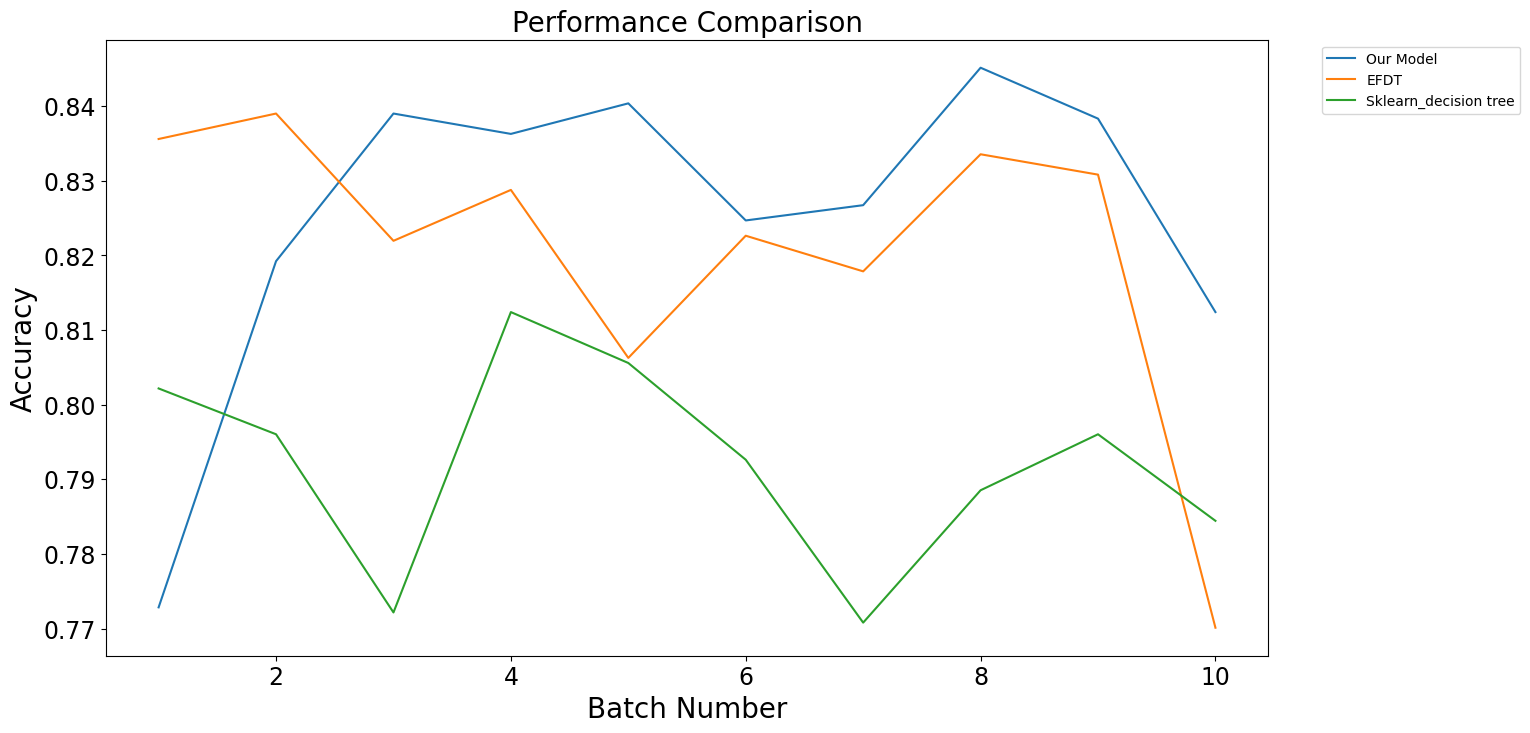

In [398]:
# This is the graph that demonstrates the performance measure at every batch on the adult dataset.
# The experiments can be replicated in the last section of the jupyter notebook.

## A demo to showcase Rule set similarity
Iris dataset analysis using regrow algorithm
In this experiment, we will be analyzing the performance of our regrow algorithm on the Iris dataset. The dataset will be split into 20% and 80% for training and testing, respectively.

#### Methodology
We will first train our original decision tree model on the 20% training dataset and generate a set of rules.
Similarly, we will train the regrown decision tree on the 80% training dataset and generate its set of rules.


We will then use the method described in the paper "A similarity measure for decision tree rules"(https://ieeexplore.ieee.org/abstract/document/6550417) to determine the similarity between the two sets of rules.
Next, we will repeat the same steps using the Extremely Fast Decision Tree (EFDT) algorithm. 

We will train an EFDT model on the 20% training dataset and generate its set of rules using a separate function that converts the EFDT model to a set of rules.

We will then train another EFDT model on the 80% training dataset and generate its set of rules. We will use the same similarity measure as above to determine the similarity between the two sets of EFDT rules.

In [2]:
# Convert the iris data into batches
iris = load_iris()
data1 = pd.DataFrame(
    data=np.c_[iris["data"], iris["target"]], columns=iris["feature_names"] + ["target"]
)

idx = random.sample(list(range(0, len(iris.data))), k=len(iris.data))
batch_size = len(iris.data) // 10
batch_idx = idx[:batch_size]
full_idx = idx[batch_size:]
X_batch, y_batch = iris.data[batch_idx], iris.target[batch_idx]
X_full, y_full = iris.data[full_idx], iris.target[full_idx]


# Batch formation for the EFDT Model
# Twenty percent of the data
part_20 = data1.sample(frac=0.20)

#  Rest of the 80% of the data
rest_part_80 = data1.drop(part_20.index)


X_batch_efdt, y_batch_efdt = part_20[iris.feature_names], part_20["target"]
X_full_efdt, y_full_efdt = rest_part_80[iris.feature_names], rest_part_80["target"]


from tree_diff import tree, keep_regrow_alg

batch_tree = tree.grow_tree(
    pd.DataFrame(X_batch, columns=iris.feature_names), y_batch, max_depth=4
)
full_clf = keep_regrow_alg.grow_tree(
    pd.DataFrame(X_full, columns=iris.feature_names),
    y_full,
    old_tree=batch_tree,
    max_depth=4,
    alpha=1,
    beta=1,
    regrow_func=lambda X, y, max_depth, metadata: tree.grow_tree(
        pd.DataFrame(X, columns=metadata.column_names), y, max_depth=max_depth
    ),
)

# Similarity between the rule-sets for the keep-regrow and original tree 
print(
    rule_set_similarity(
        tuple_tree_conversion(full_clf), tuple_tree_conversion(batch_tree)
    )
)

import river
from river import tree

model_batch = tree.ExtremelyFastDecisionTreeClassifier(
    grace_period=100,
    delta=1e-5,
    # nominal_attributes=features,
    min_samples_reevaluate=100,
)


metric = metrics.Accuracy()
evaluate.progressive_val_score(
    stream.iter_pandas(X_batch_efdt, y_batch_efdt), model_batch, metric
)


# Training on the full dataset
model_full = tree.ExtremelyFastDecisionTreeClassifier(
    grace_period=100,
    delta=1e-5,
    # nominal_attributes=features,
    min_samples_reevaluate=100,
)


metric = metrics.Accuracy()
evaluate.progressive_val_score(
    stream.iter_pandas(X_full_efdt, y_full_efdt), model_full, metric
)


# The Ruleset similarity between a batch EFDT tree (20%) and with 80% as well.
print(rule_set_similarity(
    Ruleset(river_extract_rules(model_batch._root, river_children, river_is_leaf)),
    Ruleset(river_extract_rules(model_full._root, river_children, river_is_leaf)),
))

0.9840510366826156
0.0


### Experimentation of similarity for multiple datasets 

We aim to calculate the similarity between trees trained on two batches of the same dataset. 
The dataset is specified below:
* Adult Income Dataset (https://archive.ics.uci.edu/ml/datasets/adult)
* Higgs Dataset (https://archive.ics.uci.edu/ml/datasets/HIGGS)
* Mushrooms Dataset (https://archive.ics.uci.edu/ml/datasets/mushroom)
* Android Malware Dataset (https://archive.ics.uci.edu/ml/datasets/TUANDROMD+%28+Tezpur+University+Android+Malware+Dataset%29)

We visualize the similarity by plotting for each dataset. The visualization consists of our tree (regrow algorithm) and the extremely fast decision tree.

In [111]:
alpha_beta_similarity = {}
efdt_similarity = {}

In [10]:
# Read the dataset in the csv format
# Apply data engineering
def read_data(dataset, predict_label):

    df = pd.read_csv("{}.csv".format(dataset))
    df = data_engineering(df, dataset)

    features = [l for l in list(df.columns) if not l == predict_label]

    return df, features


# Create subsequent batches of dataset
def create_batches(df, n):
    num_batches = n
    batch_size = len(df) // num_batches

    # Shuffle the dataframe
    df = df.sample(frac=1).reset_index(drop=True)

    # Divide the dataframe into batches
    batches = []
    for i in range(num_batches):
        start = i * batch_size
        end = (i + 1) * batch_size
        batch = df[start:end]
        batches.append(batch)
    return batches


# Uncomment the namw and label tag for corresponding data

# name, label = "HIGGS", "prediction"
name, label = "adult_csv", "class"
# name, label = "TUANDROMD" , "Label"
# name,label =  "mushrooms", "class"

df, features = read_data(name, label)


# Create batches for the dataset
batches = create_batches(df, 2)


X_batch, y_batch = batches[0][features], batches[0][label]

X_batch_two, y_batch_two = batches[1][features], batches[1][label]


X_batch_train, X_batch_test, y_batch_train, y_batch_test = train_test_split(
    X_batch, y_batch, random_state=2
)
(
    X_batch_two_train,
    X_batch_two_test,
    y_batch_two_train,
    y_batch_two_test,
) = train_test_split(X_batch_two, y_batch_two, random_state=2)


# A import is use every time while distinguinshing between keep_regrow tree or otherwise
from tree_diff import tree, keep_regrow_alg

batch_tree = tree.grow_tree(
    pd.DataFrame(X_batch_train, columns=features), y_batch_train, max_depth=8
)

full_clf = keep_regrow_alg.grow_tree(
    pd.DataFrame(X_batch_two_train, columns=features),
    y_batch_two_train,
    old_tree=batch_tree,
    alpha=1,
    beta=1,
    regrow_func=lambda X, y, max_depth, metadata: tree.grow_tree(
        pd.DataFrame(X, columns=metadata.column_names), y, max_depth=max_depth
    ),
)


sim1 = similar_tree.rule_set_similarity(
    tree_ruleset_conversion.tuple_tree_conversion(full_clf),
    tree_ruleset_conversion.tuple_tree_conversion(batch_tree),
)

alpha_beta_similarity = {name: sim1}


# Change the nominal attributes regarding the features of the dataset
# Specify any corresponding feature which are categorical
from river import tree

model_batch = tree.ExtremelyFastDecisionTreeClassifier(
    grace_period=100,
    delta=1e-5,
    nominal_attributes=features,
    min_samples_reevaluate=100,
)


metric = metrics.Accuracy()
evaluate.progressive_val_score(
    stream.iter_pandas(X_batch_train, y_batch_train), model_batch, metric
)


model_full = tree.ExtremelyFastDecisionTreeClassifier(
    grace_period=100,
    delta=1e-5,
    nominal_attributes=features,
    min_samples_reevaluate=100,
)

metric = metrics.Accuracy()
evaluate.progressive_val_score(
    stream.iter_pandas(X_batch_two_train, y_batch_two_train), model_full, metric
)


sim2 = similar_tree.rule_set_similarity(
    Ruleset(river_extract_rules(model_batch._root, river_children, river_is_leaf)),
    Ruleset(river_extract_rules(model_full._root, river_children, river_is_leaf)),
)

efdt_similarity = {name: sim2}

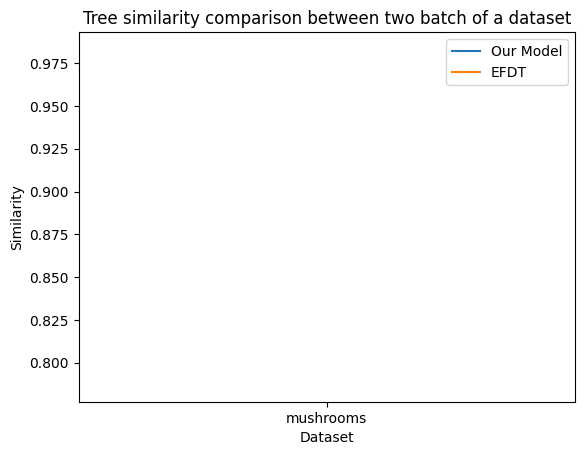

In [113]:
x = list(alpha_beta_similarity.keys())
y1 = list(alpha_beta_similarity.values())
y2 = list(efdt_similarity.values())


plt.plot(x, y1, label="Our Model")
plt.plot(x, y2, label="EFDT")


plt.xlabel("Dataset")
plt.ylabel("Similarity")
plt.title("Tree similarity comparison between two batch of a dataset")
plt.legend()
plt.show()

### Performance Measure 

We aim to measure the performance ability of our model by analyzing its performance on different batches of data. Following the same approach as in the previous experiment, we have divided the dataset into batches and filled out the dictionary for each of the batch values for the efdt tree, original tree, and regrow tree. 

The graphs presented below will showcase the performance of each batch of data with respect to testing accuracy. Additionally, we have included a line plot and a graph plot to demonstrate the average accuracy of the two batches of data.


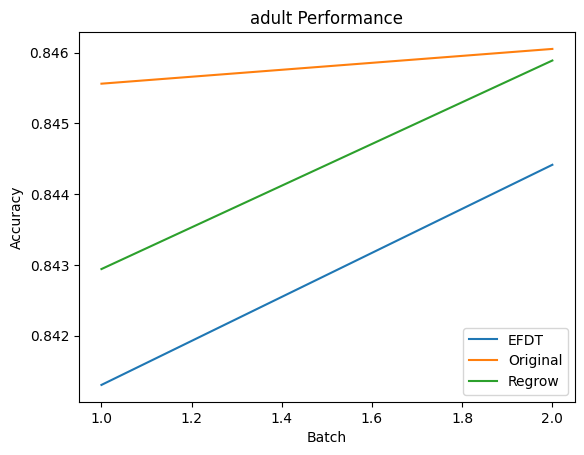

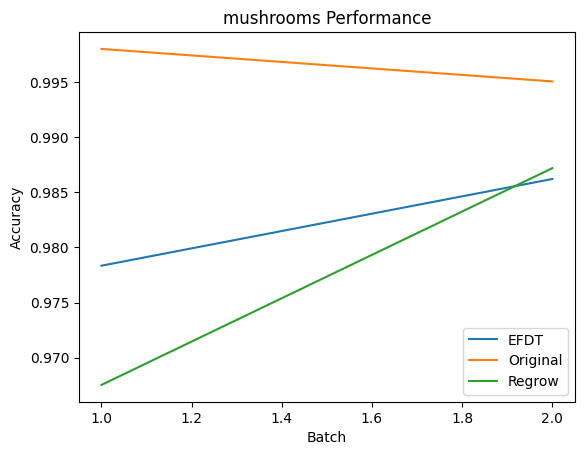

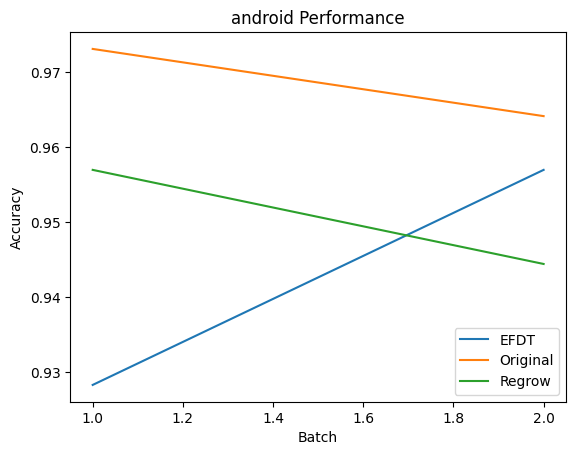

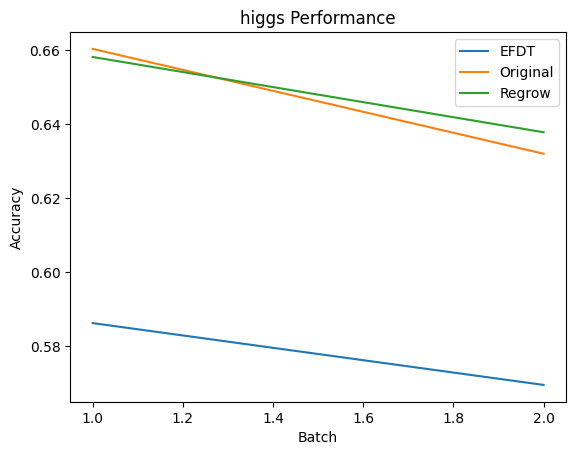

In [492]:
import matplotlib.pyplot as plt

efdt_tree = {
    "adult": [{"batch_one": 0.841303635768097, "batch_two": 0.8444153291844088}],
    "mushrooms": [{"batch_one": 0.9783464566929134, "batch_two": 0.9862204724409449}],
    "android": [{"batch_one": 0.9283154121863799, "batch_two": 0.956989247311828}],
    "higgs": [{"batch_one": 0.5861818181818181, "batch_two": 0.5694545454545454}],
}

original_tree = {
    "adult": [{"batch_one": 0.8455617425483132, "batch_two": 0.846053062561415}],
    "mushrooms": [{"batch_one": 0.9980314960629921, "batch_two": 0.9950787401574803}],
    "android": [{"batch_one": 0.9731182795698925, "batch_two": 0.96415770609319}],
    "higgs": [{"batch_one": 0.6603636363636364, "batch_two": 0.632}],
}

regrow_tree = {
    "adult": [{"batch_one": 0.8429413691451032, "batch_two": 0.8458892892237144}],
    "mushrooms": [{"batch_one": 0.96751968503937, "batch_two": 0.9872047244094488}],
    "android": [{"batch_one": 0.956989247311828, "batch_two": 0.9444444444444444}],
    "higgs": [{"batch_one": 0.6581818181818182, "batch_two": 0.6378181818181818}],
}

for dataset in efdt_tree.keys():
    # Extract the performance values for each batch
    efdt_values = [
        efdt_tree[dataset][i]["batch_one"] for i in range(len(efdt_tree[dataset]))
    ]
    efdt_values += [
        efdt_tree[dataset][i]["batch_two"] for i in range(len(efdt_tree[dataset]))
    ]

    original_values = [
        original_tree[dataset][i]["batch_one"]
        for i in range(len(original_tree[dataset]))
    ]
    original_values += [
        original_tree[dataset][i]["batch_two"]
        for i in range(len(original_tree[dataset]))
    ]

    regrow_values = [
        regrow_tree[dataset][i]["batch_one"] for i in range(len(regrow_tree[dataset]))
    ]
    regrow_values += [
        regrow_tree[dataset][i]["batch_two"] for i in range(len(regrow_tree[dataset]))
    ]

    # Plot the performance values
    plt.plot(range(1, len(efdt_values) + 1), efdt_values, label="EFDT")
    plt.plot(range(1, len(original_values) + 1), original_values, label="Original")
    plt.plot(range(1, len(regrow_values) + 1), regrow_values, label="Regrow")
    plt.title(f"{dataset} Performance")
    plt.xlabel("Batch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

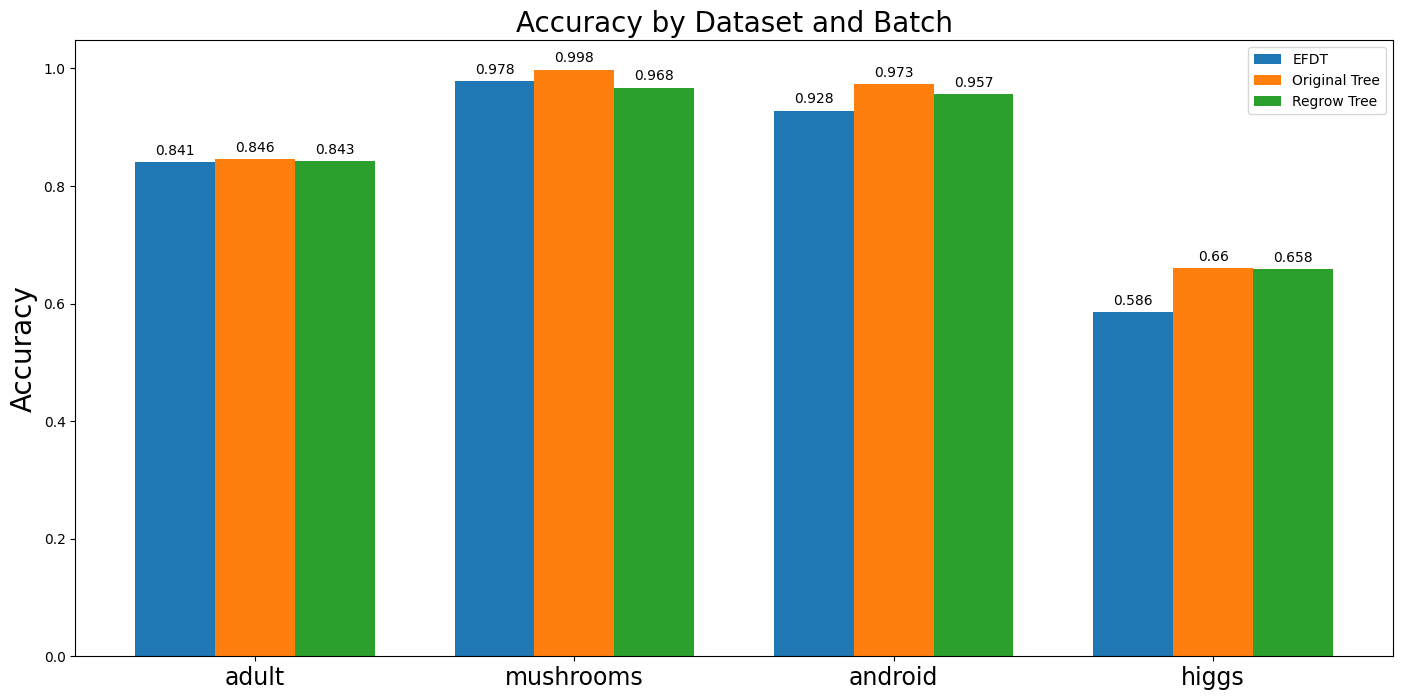

In [501]:
import matplotlib.pyplot as plt
import numpy as np

datasets = list(efdt_tree.keys())
batches = ["batch_one", "batch_two"]
models = ["efdt_tree", "original_tree", "regrow_tree"]

width = 0.25  # the width of the bars
x = np.arange(len(datasets))

fig, ax = plt.subplots(figsize=(17, 8))
rects1 = ax.bar(
    x - width, [efdt_tree[d][0]["batch_one"] for d in datasets], width, label="EFDT"
)
rects2 = ax.bar(
    x,
    [original_tree[d][0]["batch_one"] for d in datasets],
    width,
    label="Original Tree",
)
rects3 = ax.bar(
    x + width,
    [regrow_tree[d][0]["batch_one"] for d in datasets],
    width,
    label="Regrow Tree",
)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Accuracy", fontsize=20)
ax.set_title("Accuracy by Dataset and Batch", fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(datasets, fontsize=17)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            "{}".format(round(height, 3)),
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha="center",
            va="bottom",
        )


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.show()

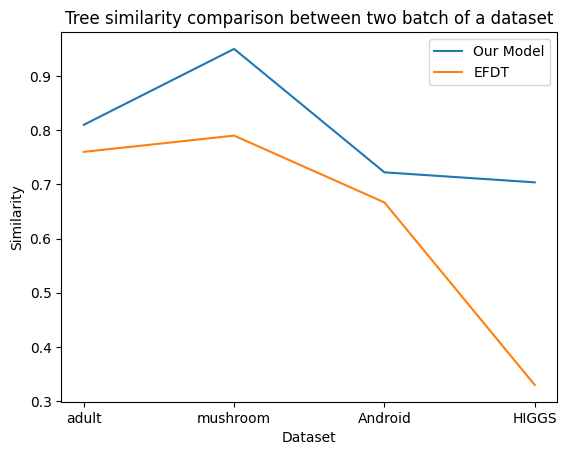

In [392]:
# I have specified the graph below that demonstrates the similarity comparison
# between the keep-regrow and the EFDT model.
# Moreover, further experiments are aligned to show for each tree (original keep_regrow)

### Experiment on Hyperparameter Tuning
In this experiment, we aim to analyze the performance of our model for every combination of values of alpha, beta, and max_depth. 
To achieve this, we have divided the dataset into batches and further divided each batch into train and test splits. 
We have also analyzed the full dataset while excluding each batch with the same values of alpha, beta, and max_depth, using train and test splits.
The ultimate goal of this experiment is to determine the best hyperparameter values for our algorithm.

#### Dataset
The dataset used in this experiment is [Iris Dataset].

#### Experimental Setup
We performed a grid search over the combinations of the following hyperparameters:

alpha: [0.1,1.0]

beta: [0.1,1.0] 

max_depth: [2,3,4]


For each combination of hyperparameters, we divided the dataset into batches and further split each batch into 70% training and 30% testing data. We aim to grow our tree on the training data and evaluated its performance on the testing data. 


In [3]:
# Data Engineering for IRIS DATA
random.seed(2)
iris = load_iris()
idx = random.sample(list(range(0, len(iris.data))), k=len(iris.data))
batch_size = len(iris.data) // 10
batch_idx = idx[:batch_size]
full_idx = idx[batch_size:]
X_batch, y_batch = iris.data[batch_idx], iris.target[batch_idx]
X_full, y_full = iris.data[full_idx], iris.target[full_idx]

In [15]:
from tree_diff import tree, keep_regrow_alg

# Load dataset
# Split batch dataset into train and test
X_batch_train, X_batch_test, y_batch_train, y_batch_test = train_test_split(
    X_batch, y_batch, test_size=0.3, random_state=2
)

# Split full dataset into train and test, but exclude data used in batch dataset
X_full_train, X_full_test, y_full_train, y_full_test = train_test_split(
    X_full, y_full, test_size=0.3, random_state=2, stratify=y_full
)

# Define a range of hyperparameter values to test
alphas = [0.1, 1.0]
betas = [0.1, 1.0]
max_depths = [2, 3, 4]

batch_train_accuracy_comb = []
batch_test_accuracy_comb = []
batch_precision_comb = []
batch_recall_comb = []

full_train_accuracy_comb = []
full_test_accuracy_comb = []
full_precision_comb = []
full_recall_comb = []

# Evaluate the re_grow_tree function for each hyperparameter combination
for alpha, beta, max_depth in itertools.product(alphas, betas, max_depths):

    # Train decision tree classifier on batch dataset
    batch_tree = tree.grow_tree(
        pd.DataFrame(X_batch_train, columns=iris.feature_names),
        y_batch_train,
        max_depth=max_depth,
    )

    # print([X_batch_train[i] for i in range(0, X_batch_train.shape[0])])
    # Evaluate decision tree classifier on batch dataset
    batch_y_train = [
        batch_tree.predict(X_batch_train[i]) for i in range(0, X_batch_train.shape[0])
    ]
    batch_y_pred = [
        batch_tree.predict(X_batch_test[i]) for i in range(0, X_batch_test.shape[0])
    ]
    batch_accuracy = np.mean(batch_y_pred == y_batch_test)
    batch_train_accuracy = np.mean(batch_y_train == y_batch_train)
    # batch_confusion = confusion_matrix(y_batch_test, batch_y_pred)
    batch_precision = precision_score(y_batch_test, batch_y_pred, average="weighted")

    batch_recall = recall_score(y_batch_test, batch_y_pred, average="weighted")

    batch_test_accuracy_comb.append(batch_accuracy)
    batch_recall_comb.append(batch_recall)
    batch_precision_comb.append(batch_precision)
    batch_train_accuracy_comb.append(batch_train_accuracy)

    # Re-grow decision tree on full dataset using re_grow_tree function

    full_clf = keep_regrow_alg.grow_tree(
        pd.DataFrame(X_full_train, columns=iris.feature_names),
        y_full_train,
        old_tree=batch_tree,
        max_depth=max_depth,
        alpha=alpha,
        beta=beta,
        regrow_func=lambda X, y, max_depth, metadata: tree.grow_tree(
            pd.DataFrame(X, columns=metadata.column_names), y, max_depth=max_depth
        ),
    )

    # Evaluate decision tree classifier on full dataset
    full_y_train = [
        full_clf.predict(X_full_train[i]) for i in range(0, X_full_train.shape[0])
    ]
    full_y_pred = [
        full_clf.predict(X_full_test[i]) for i in range(0, X_full_test.shape[0])
    ]
    full_accuracy = np.mean(full_y_pred == y_full_test)
    full_train_accuracy = np.mean(full_y_train == y_full_train)

    # full_confusion = confusion_matrix(y_full_test, full_y_pred)
    full_precision = precision_score(y_full_test, full_y_pred, average="weighted")
    full_recall = recall_score(y_full_test, full_y_pred, average="weighted")

    full_test_accuracy_comb.append(full_accuracy)
    full_recall_comb.append(full_recall)
    full_precision_comb.append(full_precision)
    full_train_accuracy_comb.append(full_train_accuracy)

    # Print results
    print(f"alpha={alpha}, beta={beta}, max_depth={max_depth}")
    print("Batch dataset:")
    print(
        f"batch_train_accuracy = {batch_train_accuracy}, batch_test_accuracy = {batch_accuracy}, batch_precision = {batch_precision}, batch_recall = {batch_recall}"
    )
    print("Full dataset")
    print(
        f"full_train_accuracy = {full_train_accuracy}, full_test_accuracy = {full_accuracy},full_precision = {full_precision}, full_recall = {full_recall}"
    )

### Analyzing Performance of Decision Tree Algorithms on Adult Dataset
In this experiment, we aim to analyze the performance of three decision tree algorithms on the Adult dataset. The dataset has been divided into 10 batches, and for each batch, we have calculated the train and test split.

The following three types of decision tree algorithms have been used in this experiment:

* Decision Tree
* Our Tree (Regrow algorithm)
* Extremely Fast Decision Tree (EFDT)

For each type of decision tree, we have calculated the testing accuracy for each batch of the data. The results have been stored in a dictionary for each type of decision tree. The dictionary contains a list of dictionaries, where each dictionary represents the testing accuracy for each batch of the data.


To visualize the performance of each type of decision tree, we will plot a line graph using Matplotlib. The x-axis of the graph will represent the batch number, and the y-axis will represent the testing accuracy. The graph will have three lines, one for each type of decision tree.

In [14]:
from tree_diff import tree, keep_regrow_alg

alpha_beta = {}
efdt = {}
sklearn_dt = {}

# create 10 batches for the dataset
df, features = read_data("adult_csv", "class")
batches = create_batches(df, 10)

X_start, y_start = batches[0][features].to_numpy(), batches[0]["class"].to_numpy()
X_start_train, X_start_test, y_start_train, y_start_test = train_test_split(
    X_start, y_start, test_size=0.3, random_state=2
)

batch_start = tree.grow_tree(
    pd.DataFrame(X_start_train, columns=features), y_start_train
)

start_y_pred = [
    batch_start.predict(X_start_test[i]) for i in range(0, X_start_test.shape[0])
]
start_accuracy = np.mean(start_y_pred == y_start_test)

alpha_beta[1] = start_accuracy

print(alpha_beta)


X_start, y_start = batches[0][features], batches[0]["class"]
X_start_train, X_start_test, y_start_train, y_start_test = train_test_split(
    X_start, y_start, test_size=0.3, random_state=2
)

from river import tree
# EFDT Applied from the PyPI: River
model = tree.ExtremelyFastDecisionTreeClassifier(
    grace_period=100,
    delta=1e-5,
    nominal_attributes=[
        "workclass",
        "education",
        "marital-status",
        "occupation",
        "relationship",
        "race",
        "native-country",
        "sex",
    ],
    min_samples_reevaluate=100,
)

metric = metrics.Accuracy()
evaluate.progressive_val_score(
    stream.iter_pandas(X_start_train, y_start_train), model, metric
)

y_start_pred = []
for x, y in stream.iter_pandas(X_start_test, y_start_test):
    y_start_pred.append(model.predict_one(x))

full_accuracy = np.mean(y_start_pred == y_start_test)

efdt[1] = full_accuracy

from sklearn import tree

dtcl = tree.DecisionTreeClassifier()

dtcl = dtcl.fit(X_start_train, y_start_train)

y_pred_dtcl = dtcl.predict(X_start_test)

dt_accuracy = np.mean(y_pred_dtcl == y_start_test)

sklearn_dt[1] = dt_accuracy


print(efdt)

In [ ]:
batches.pop(0)

i = 2
batch_splits = []
for batch in batches:

    # Keep - Regrow Algorithm
    X_start, y_start = batch[features].to_numpy(), batch["class"].to_numpy()

    X_start_train, X_start_test, y_start_train, y_start_test = train_test_split(
        X_start, y_start, test_size=0.3, random_state=2
    )

    full_clf = keep_regrow_alg.grow_tree(
        pd.DataFrame(X_start_train, columns=features),
        y_start_train,
        old_tree=batch_start,
        alpha=1,
        beta=1,
        regrow_func=lambda X, y, max_depth, metadata: tree.grow_tree(
            pd.DataFrame(X, columns=metadata.column_names), y, max_depth=max_depth
        ),
    )

    start_y_pred = [
        full_clf.predict(X_start_test[i]) for i in range(0, X_start_test.shape[0])
    ]
    start_accuracy = np.mean(start_y_pred == y_start_test)

    alpha_beta[i] = start_accuracy

    # EFDT Evaluation in batches
    from river import tree

    X_start, y_start = batch[features], batch["class"]
    X_start_train, X_start_test, y_start_train, y_start_test = train_test_split(
        X_start, y_start, test_size=0.3, random_state=2
    )

    model = tree.ExtremelyFastDecisionTreeClassifier(
        grace_period=100,
        delta=1e-5,
        nominal_attributes=[
            "workclass",
            "education",
            "marital-status",
            "occupation",
            "relationship",
            "race",
            "native-country",
            "sex",
        ],
        min_samples_reevaluate=100,
    )

    metric = metrics.Accuracy()
    evaluate.progressive_val_score(
        stream.iter_pandas(X_start_train, y_start_train), model, metric
    )

    y_start_pred = []
    for x, y in stream.iter_pandas(X_start_test, y_start_test):
        y_start_pred.append(model.predict_one(x))

    full_accuracy = np.mean(y_start_pred == y_start_test)

    efdt[i] = full_accuracy

    batch_start = full_clf

    # Decision Tree Implimentation
    from sklearn import tree

    dtcl = tree.DecisionTreeClassifier()

    dtcl = dtcl.fit(X_start_train, y_start_train)

    y_pred_dtcl = dtcl.predict(X_start_test)

    dt_accuracy = np.mean(y_pred_dtcl == y_start_test)

    sklearn_dt[i] = dt_accuracy

    i += 1

In [ ]:
plt.figure(figsize=(15, 8))

x = list(alpha_beta.keys())
y1 = list(alpha_beta.values())
y2 = list(efdt.values())
y3 = list(sklearn_dt.values())

plt.plot(x, y1, label="Our Model")
plt.plot(x, y2, label="EFDT")
plt.plot(x, y3, label="Sklearn_decision tree")


plt.xlabel("Batch Number", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.title("Performance Comparison", fontsize=20)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()